# Синтез изображений

Задание 8

Реализовать синтезирование лиц из LFW с помощью DCGAN
Библиотеки: [Python, Tensorflow]

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

import tensorflow_datasets as tfds

C:\Users\Windows\.conda\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Windows\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\Windows\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Windows\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


## Загрузить LFW Датасет

In [3]:
full_y, full_x = tfds.as_numpy(tfds.load(
    'lfw',
    split='train',    
    batch_size=-1,
    as_supervised=True
))

In [4]:
train_x = full_x[:10000,...]
train_y = full_y[:10000,...]
test_x = full_x[10000:,...]
test_y = full_y[10000:,...]

In [5]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(10000, 250, 250, 3)
(10000,)
(3233, 250, 250, 3)
(3233,)


In [6]:
# уменьшим размеры картинок, чтобы сеть быстрее обучалась
new_width=56
new_heigh=56

In [7]:
type(train_x)

numpy.ndarray

In [8]:
tmp_train_x=[]
for i in range(train_x.shape[0]):
    tmp_train_x.append(cv2.resize(train_x[i, ...], (new_width, new_heigh)))
    
train_x=np.array(tmp_train_x)
print(train_x.shape)

tmp_test_x=[]
for i in range(test_x.shape[0]):
    tmp_test_x.append(cv2.resize(test_x[i, ...], (new_width, new_heigh)))
    
test_x=np.array(tmp_test_x)
print(test_x.shape)



(10000, 56, 56, 3)
(3233, 56, 56, 3)


In [9]:
#при таком нормировании картинки получаются темными и неестественными, также есть предупреждения
#train_x = (train_x.reshape(-1, new_width*new_heigh*3).astype(np.float32) - 127.5) / 127.5
#test_x = (test_x.reshape(-1, new_width*new_heigh*3).astype(np.float32) - 127.5) / 127.5

train_x = train_x.reshape(-1, new_width * new_heigh * 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, new_width * new_heigh * 3).astype(np.float32) / 255.

In [10]:
print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

(10000, 9408) float32
0.0 1.0


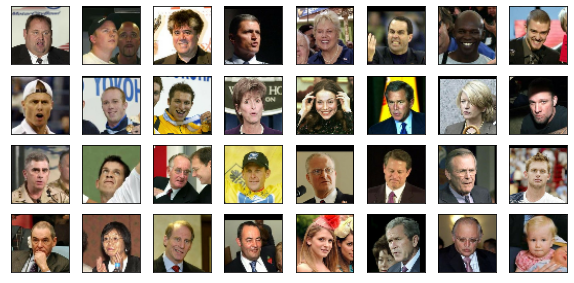

In [11]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(new_width, new_heigh,3))
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

In [19]:
def plot_digits_ex(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...])
        plt.xticks([]), plt.yticks([])
    plt.show()

## Построение модели

## Deep Convolutional GAN (DCGAN) Generator, Discriminator

In [22]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [28]:
INPUT_DIM = 100
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, new_width, new_heigh, 3))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

(16, 56, 56, 3)


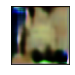

In [29]:
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
print(syntetic_images.shape)
plot_digits_ex(syntetic_images[0:1,...])


[Step  0] D Loss: 0.1424; G Loss: 4.1238


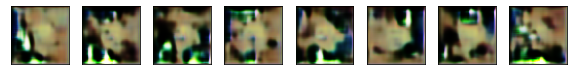

[Step 200] D Loss: 0.0667; G Loss: 6.0571


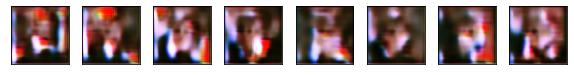

[Step 400] D Loss: 0.1172; G Loss: 5.0603


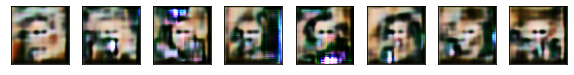

[Step 600] D Loss: 0.7374; G Loss: 0.8567


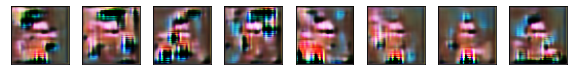

[Step 800] D Loss: 0.4476; G Loss: 6.6288


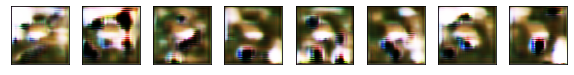

[Step 1000] D Loss: 0.2376; G Loss: 2.5135


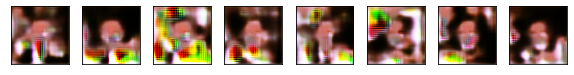

[Step 1200] D Loss: 0.4326; G Loss: 3.1876


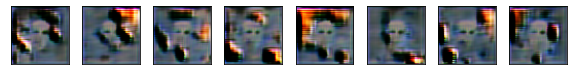

[Step 1400] D Loss: 0.3160; G Loss: 8.0279


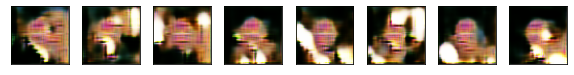

[Step 1600] D Loss: 0.2685; G Loss: 3.0304


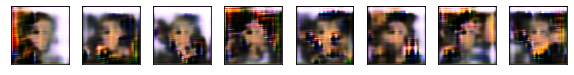

[Step 1800] D Loss: 0.1467; G Loss: 5.8214


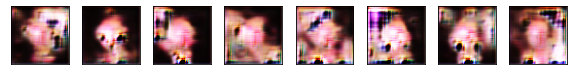

[Step 2000] D Loss: 0.1569; G Loss: 4.3325


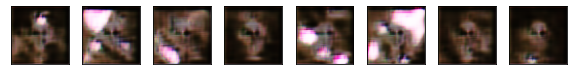

[Step 2200] D Loss: 0.5070; G Loss: 1.7570


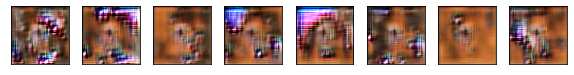

[Step 2400] D Loss: 0.4247; G Loss: 4.6279


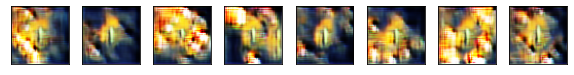

[Step 2600] D Loss: 0.3657; G Loss: 2.2354


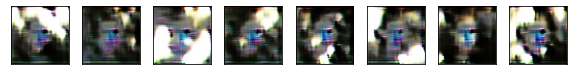

[Step 2800] D Loss: 0.1669; G Loss: 4.9467


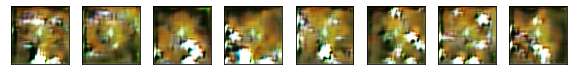

[Step 3000] D Loss: 0.1720; G Loss: 2.0604


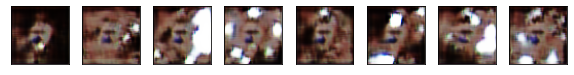

[Step 3200] D Loss: 0.3947; G Loss: 4.4444


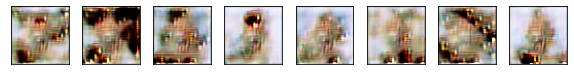

[Step 3400] D Loss: 0.2777; G Loss: 2.3855


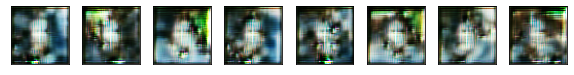

[Step 3600] D Loss: 0.7478; G Loss: 2.0175


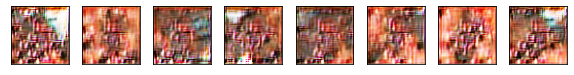

[Step 3800] D Loss: 0.5099; G Loss: 1.0522


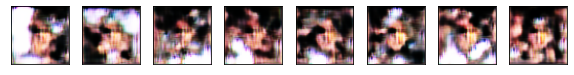

[Step 4000] D Loss: 0.3432; G Loss: 1.5849


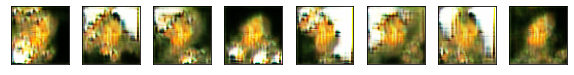

[Step 4200] D Loss: 0.3338; G Loss: 3.4708


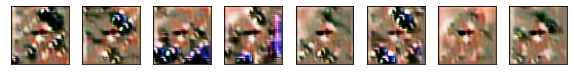

[Step 4400] D Loss: 0.4941; G Loss: 3.3114


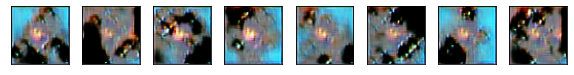

[Step 4600] D Loss: 0.4329; G Loss: 3.6612


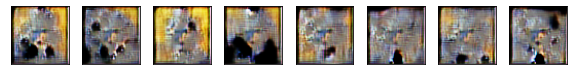

[Step 4800] D Loss: 0.3348; G Loss: 1.1608


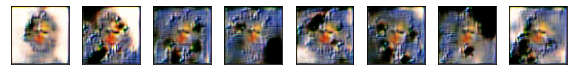

[Step 5000] D Loss: 0.4094; G Loss: 2.1093


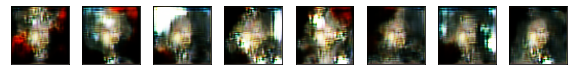

[Step 5200] D Loss: 0.7164; G Loss: 2.0546


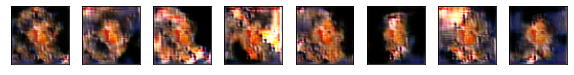

[Step 5400] D Loss: 0.1922; G Loss: 1.8858


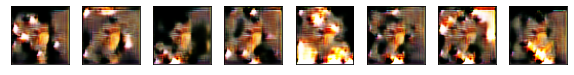

[Step 5600] D Loss: 0.4245; G Loss: 3.2468


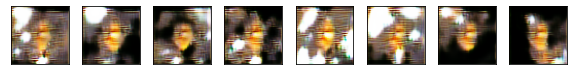

[Step 5800] D Loss: 0.0762; G Loss: 3.6483


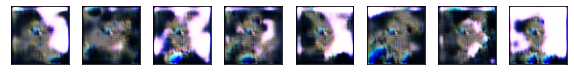

[Step 6000] D Loss: 0.0673; G Loss: 4.0215


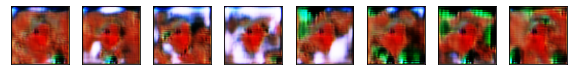

[Step 6200] D Loss: 0.6281; G Loss: 3.5871


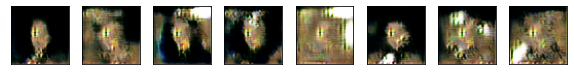

In [30]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)

## Тестирование свёрточного генератора

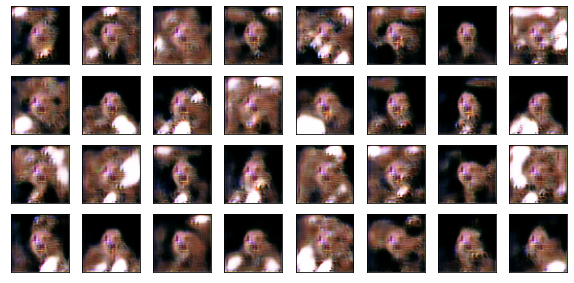

In [31]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

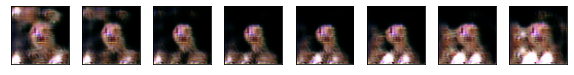

In [32]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

**Вывод: т . к . для нормальной генерации надо много эпох, что по времени сложно воспроизвести, то ограничиваемся более менее приемлемым результатом**